# Hydrodynamics

A field that we did not cover in our Python course so far is hydrodynamics. The basic hydrodynamic equations, i.e. the Navier Stokes equation is a nonlinear differential equation and its numerical solution is way beyond the scope of this course. We can, however, have a look at the solution of simple problems. The first is the study of a sphere falling under gravity in a liquid. The second is just the plotting of solutions of the Stokes equation in a streamline plot. So all of that seems to be simple as compared to the more difficult things we did recently.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

import pandas as pd
import scipy.interpolate
from scipy.integrate import odeint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Falling sphere

An object falling slowly in a viscous fluid under the influence of gravity is subject to a drag force (Stokes drag) which varies linearly with its velocity. 

![Falling Sphere](falling_sphere.png)

Its equation of motion may be written as the second order differential equation:

\begin{equation}
m\frac{d^2 z}{dt^{2}}=-\zeta\frac{dz}{dt}+mg^{\prime}
\end{equation}

where $z$ is the vertical position, $m$ the mass of the object and $\zeta$ the friction coefficient, which is for a sphere for example $\zeta=6\pi\eta R$. Here $\eta$ is the viscosity and $R$ is the radius of the particle. The gravitational force on the particle is due to bouyancy not directly given by the gravitational acceleration but by

\begin{equation}
g^{\prime}=g\left( 1-\frac{\rho_f}{\rho_o}\right )
\end{equation}


With the help of that we may write down the finam differential equation as

\begin{equation}
\frac{d^2 z}{dt^{2}}=-\frac{6\pi\eta R}{m}\frac{dz}{dt}+g\left( 1-\frac{\rho_f}{\rho_o}\right )
\end{equation}

which is easy to solve with our previously gained skills `odeint`.

### Setup

In [26]:
g = 9.81 # Acceleration due to gravity (m.s-2)
rho_Pt, rho_Hg = 21450, 13530 # Densities (kg.m-3)
eta = 1.53e-1 # Viscosity  of Hg (Pa.s)

r = 1.e-3   # radius (m)
m = 4*np.pi/3 * r**3 * rho_Pt ## mass


zeta = 6 * np.pi * eta * r ## Stoke drag coefficient


gp = g * (1 - rho_Hg/rho_Pt)  ## gravity minus bouyancy

### Function definition

In [27]:
def falling(z, t, m, c, gp):
    dz0 = z[1]
    dz1 = gp - c/m * z[1]
    return dz0, dz1

### Initial Conditions

In [28]:
t = np.linspace(0, 20, 50) ## time period
z0 = (0,  0) ## initial conditions, position and velocity

### Numerical solution

In [29]:
z, vz = odeint(falling, z0, t, args=(m, zeta, gp)).T ## integrate

### Analytical solution

In [30]:
v0, vt, tau = 0, m*gp/zeta, m/zeta
z_a = vt*t + v0*tau*(1-np.exp(-t/tau)) + vt*tau*(np.exp(-t/tau)-1)
vz_a = vt + (v0-vt)*np.exp(-t/tau)

The plots below show the change of the position, velocity vs. each other. What is nicely seen, is that the position changes initially in a parabolic way and then turns into a linear increase with time, meaning the the velocity is constant. This is seen in the other two plots, demonstrating the the friction force balances at some point the gravitational force to yield a constant velocty.

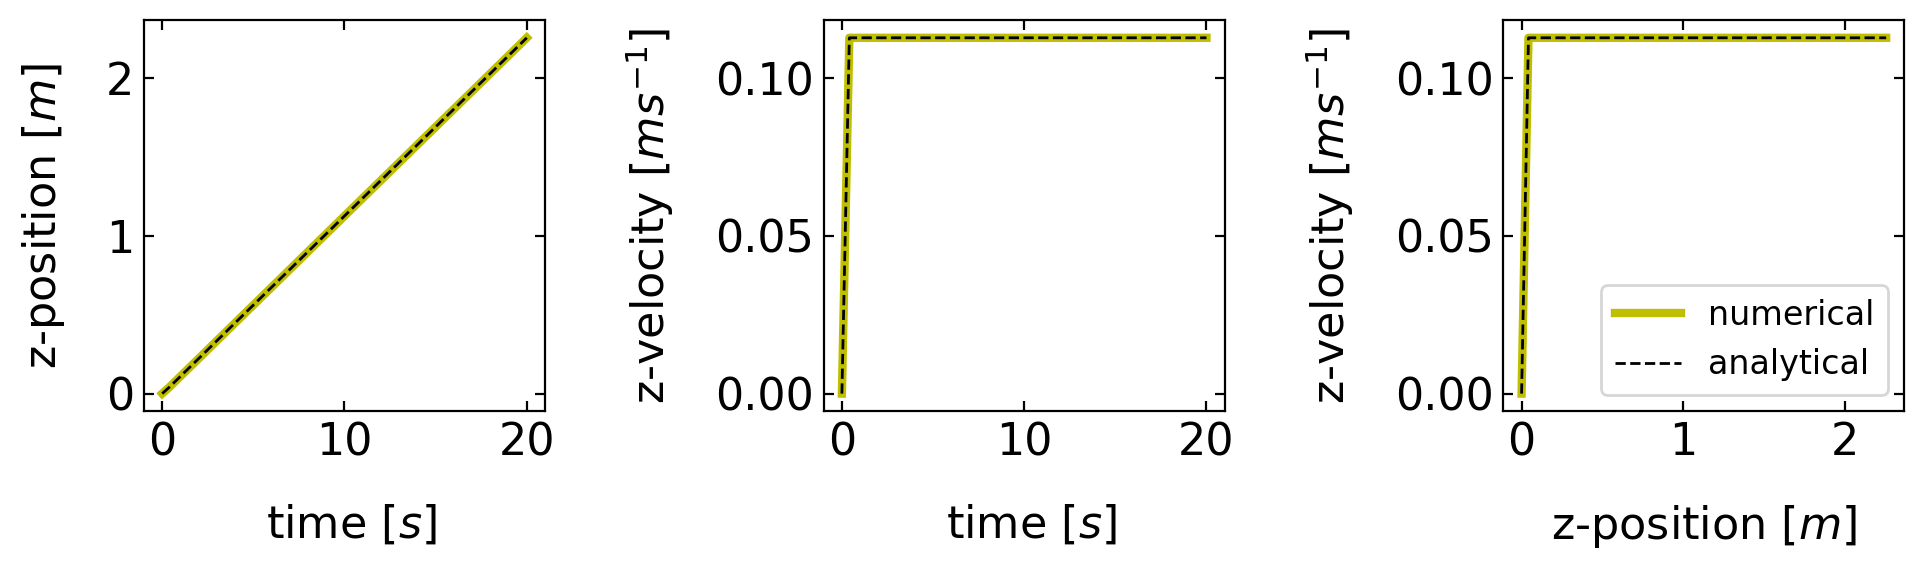

In [31]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(t,z,'y-',lw=3)
plt.plot(t,z_a,'k--',lw=1)
plt.xlabel(' time [$s$]')
plt.ylabel('z-position [$m$]')

plt.subplot(1,3,2)
plt.plot(t,vz,'y-',lw=3)
plt.plot(t,vz_a,'k--',lw=1)
plt.xlabel(' time [$s$]')
plt.ylabel('z-velocity [$m s^{-1}$]')

plt.subplot(1,3,3)
plt.plot(z,vz,'y-',lw=3,label='numerical')
plt.plot(z_a,vz_a,'k--',lw=1,label='analytical')
plt.xlabel('z-position [$m$]')
plt.ylabel('z-velocity [$m s^{-1}$]')
plt.legend()
plt.tight_layout()

plt.show()

## Stokes equation

In this second part, we will plot the streamlines of flow fields, which are particular solutions of the Stokes equation. The Stokes equation is a simplified form of the Navier-Stokes equation. The Stokes equation reads

\begin{equation}
\eta \nabla^{2}{\bf u}-\nabla p + {\bf f}=0
\end{equation}

which is always bound to a second equation

\begin{equation}
\nabla \cdot {\bf u}=0
\end{equation}

This last equation tells you that the liquid is incompressible.

We do not want to solve the Stokes equation, but we want to obtain a plot of some fundamental solutions under the condition that the velocity of the fluid vanishes at infinite distance. 

## Fundamental Solutions of the Stokes Equation


One of the fundamental solutions is created when a particle of radius $a$ that is dragged with a velocity ${\bf v}=\{v_x,v_y,v_z\}$ through a solution at low Reynolds number is causing a flow field, which corresponds in the farfield to the flow field generated by a point force acting on a volume element. The solution to that problem, which creates finally the friction coefficient we used in the first section is constructed from a so-called Stokeslet, i.e. the flow field created by a point force on a volume element of the fluid. This flow field is given by

\begin{equation}
{\bf u}_{SL}({\bf r})=\frac{3a}{4 r}\left(I+\hat{r}\hat{r}\right){\bf v}
\end{equation}

This solution, however, fails to comply with the no-slip boundary condition, i.e. the condition that the fluid and the sphere have the same velocity at the surface. 

### Stokeslet 

So lets create at first a plot of flow field of the Stokeslet. Therefore we have to calculate the out product $\hat{r}\hat{r}$ together with the identity matrix. `Numpy` provides us with the method `outer` for the outer product. A function, which delivers the stokeslet has then the following shape and returns the flow field x and y vector components.

In [33]:
def stokeslet(r,v,a):
        d=np.sqrt(r.dot(r))
        ot=3*a*(np.identity(3)+np.outer(r,r)/d/d)/d/4
        vec=ot.dot(v.transpose())
        return(vec[0],vec[1])

We would like to access the flow field in the x-y plane.

In [34]:
n=200
x=np.linspace(-10,10,n)
y=np.linspace(-10,10,n)

The flow field is created by a point force draging the particle in x-direction with the velocity 

In [35]:
v=np.array([1,0,0])

The cell below calculates the flow field at each point in the plane and inserts all into two lists. These are then reshaped into arrays.

In [36]:
uu=np.zeros([n,n])
vv=np.zeros([n,n])

a=2
z=0
for i,xp in enumerate(x):
    for j,yp in enumerate(y):
        uu[i,j],vv[i,j]=stokeslet(np.array([xp,yp,z])+np.array([0,0,0]),v,a)        

The cell below creates a plot of the streamlines. The streamlines are not lines of constant velocity. They represent the traces of the flow field a tracer particle would follow. The streamlines are plotted together with a contour plot of the velocity magnitude.

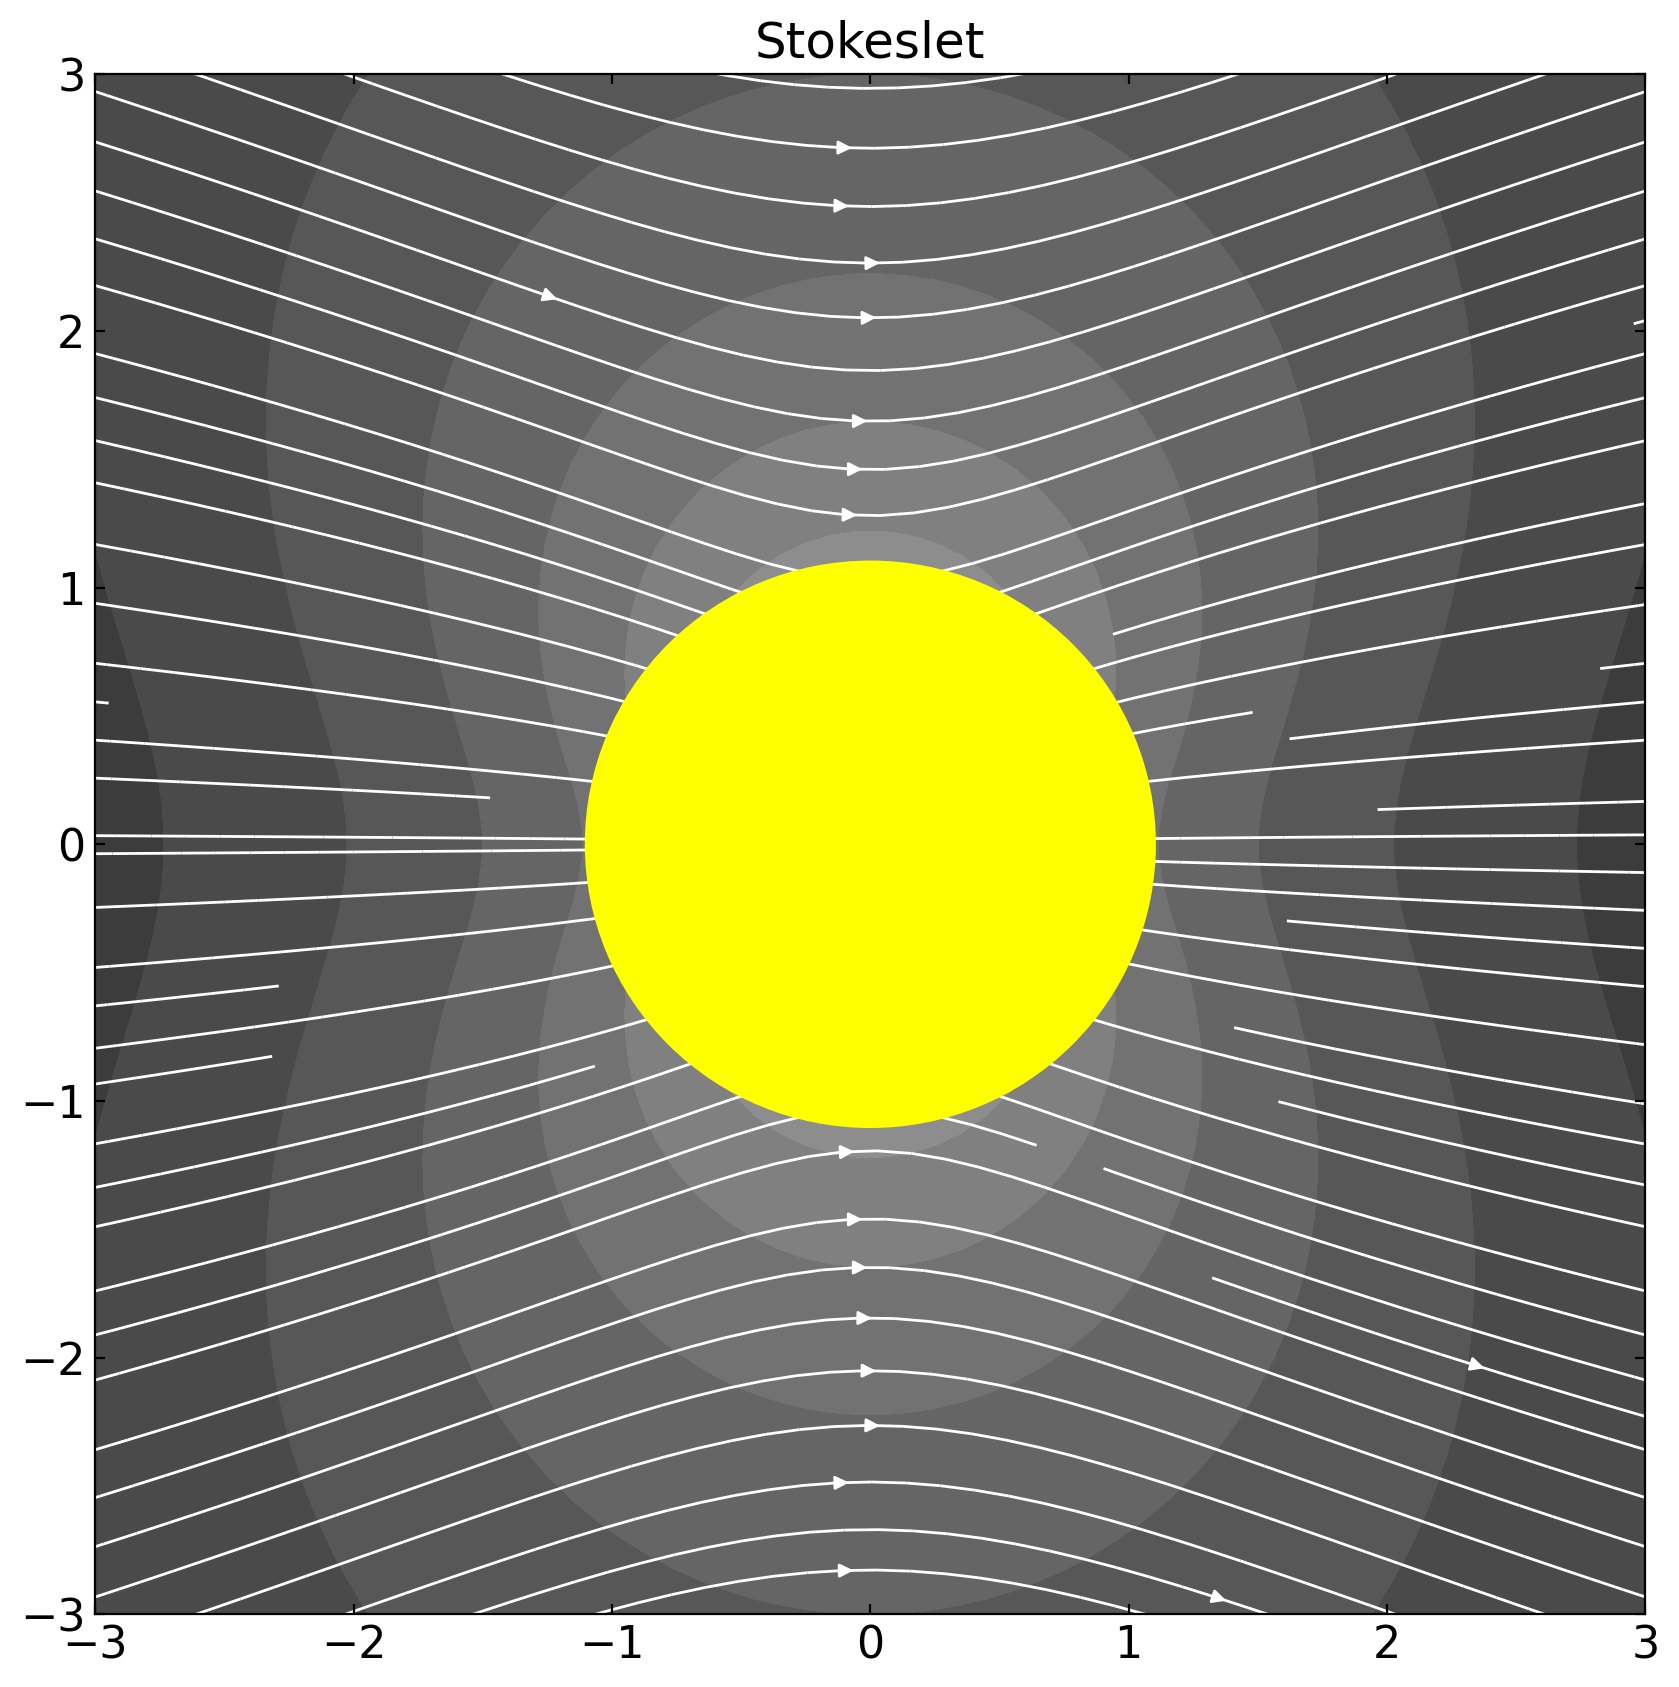

In [39]:
X,Y=np.meshgrid(x,y)


fig,ax=plt.subplots(1,1,figsize=(10,10))
mag=np.sqrt(uu**2+vv**2)
plt.contourf(X,Y,np.log(mag),levels=20,cmap='gray',zorder=-2)
plt.streamplot(X,Y,uu.transpose(),vv.transpose(),density=[5,5],linewidth=1,color="w", maxlength=100,zorder=-1)
circle1 = plt.Circle((0, 0), 1.1*a/2, lw=1, color='yellow')
ax.add_artist(circle1)
plt.title('Stokeslet')
plt.xlim(-3,3)
plt.ylim(-3,3)

plt.show()

### Source dipole

To correct for the boundary conditions at the surface of the particle we need a second flow field, which is the one of a source dipole. This source dipole is given by

\begin{equation}
{\bf u}_{SD}({\bf r})=\frac{a^3}{4 r^3}\left(I-3\hat{r}\hat{r}\right){\bf v}
\end{equation}

and represented by the function below



In [40]:
def source_dipole(r,v,a):
        d=np.sqrt(r.dot(r))
        ot=a**3*(np.identity(3)-3*np.outer(r,r)/d/d)/d**3/4
        vec=ot.dot(v.transpose())
        return(vec[0],vec[1])

We calculate the flow field in the sample plane.

In [41]:
uu=np.zeros([n,n])
vv=np.zeros([n,n])

a=2
z=0
for i,xp in enumerate(x):
    for j,yp in enumerate(y):
        uu[i,j],vv[i,j]=source_dipole(np.array([xp,yp,z])+np.array([0,0,0]),v,a)     

The streamline plot demonstrates clearly, why this flow field is called source dipole. It has a shape, which reminds us of the electric field lines of and electric dipole.

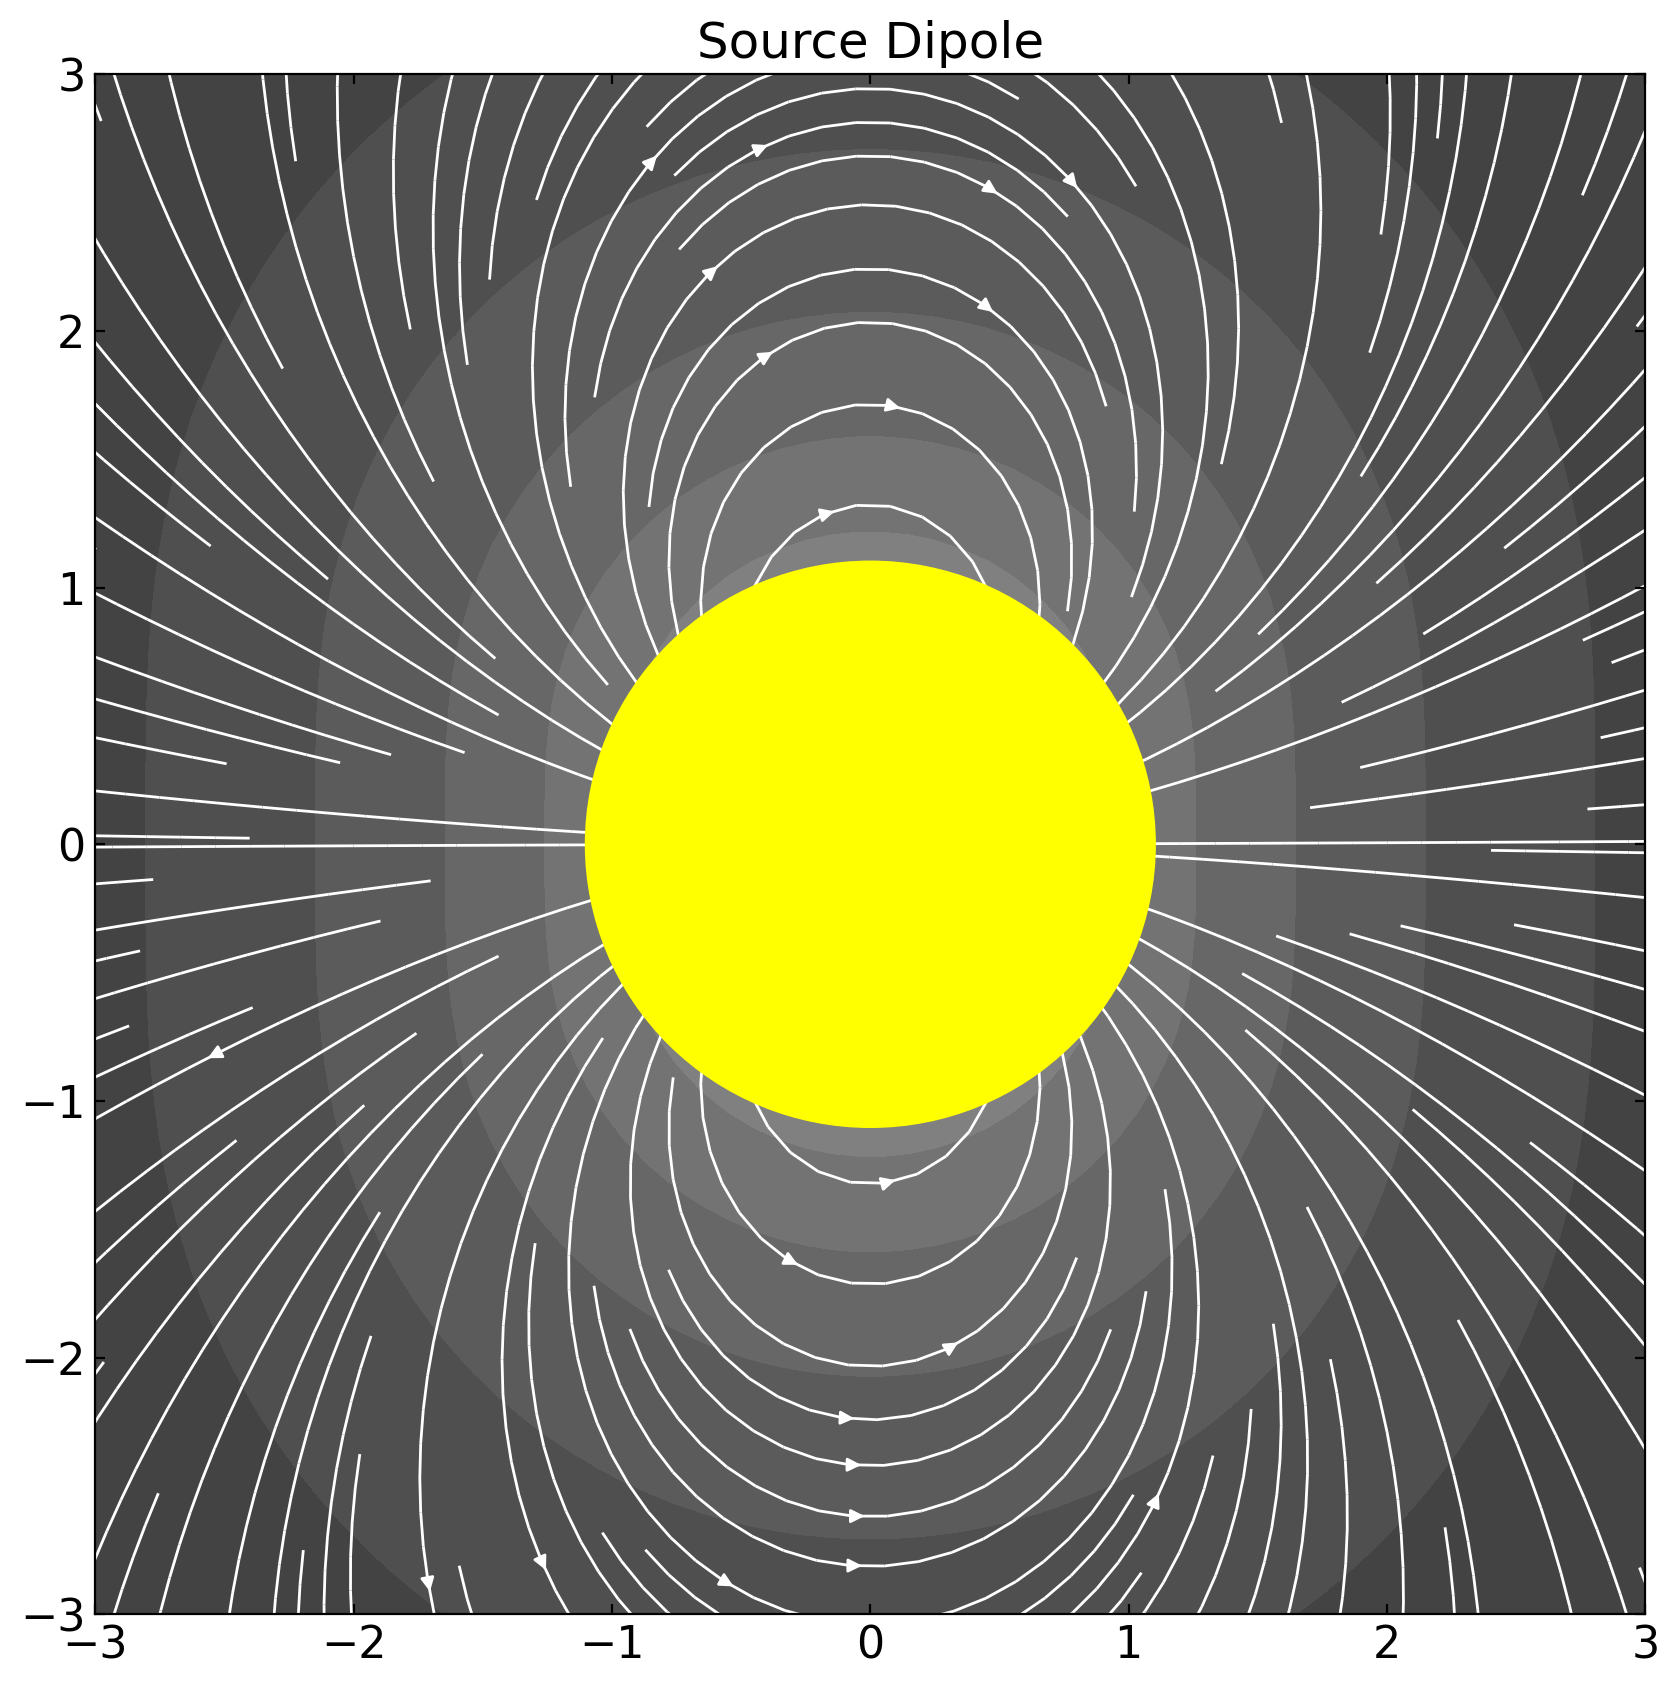

In [44]:
X,Y=np.meshgrid(x,y)
mask=np.sqrt(X**2+Y**2)<=1.9

fig,ax=plt.subplots(1,1,figsize=(10,10))
mag=np.sqrt(uu**2+vv**2)
plt.contourf(X,Y,np.log(mag),levels=20,cmap='gray',zorder=-2)
plt.streamplot(X,Y,uu.transpose(),vv.transpose(),density=[5,5],linewidth=1,color="w", maxlength=100,zorder=-1)
circle1 = plt.Circle((0, 0), 1.1*a/2, lw=1, color='yellow')
ax.add_artist(circle1)
plt.title('Source Dipole')
plt.xlim(-3,3)
plt.ylim(-3,3)

plt.show()

### Sum of both solutions

The flow field around a sphere is then the sum of both solutions. 

\begin{equation}
{\bf u}({\bf r})=\frac{3a}{4 r}\left(I+\hat{r}\hat{r}\right){\bf v}+\frac{a^3}{4 r^3}\left(I-3\hat{r}\hat{r}\right){\bf v}
\end{equation}

This is numerically calculated below.

In [45]:
uu=np.zeros([n,n])
vv=np.zeros([n,n])

a=2
z=0
for i,xp in enumerate(x):
    for j,yp in enumerate(y):
        uu[i,j],vv[i,j]=np.array(stokeslet(np.array([xp,yp,z])+np.array([0,0,0]),v,a))+np.array(source_dipole(np.array([xp,yp,z])+np.array([0,0,0]),v,a)     )

The result now clearly shows that the streamlines sneak around the sphere and not anymore end or start at the sphere surface.

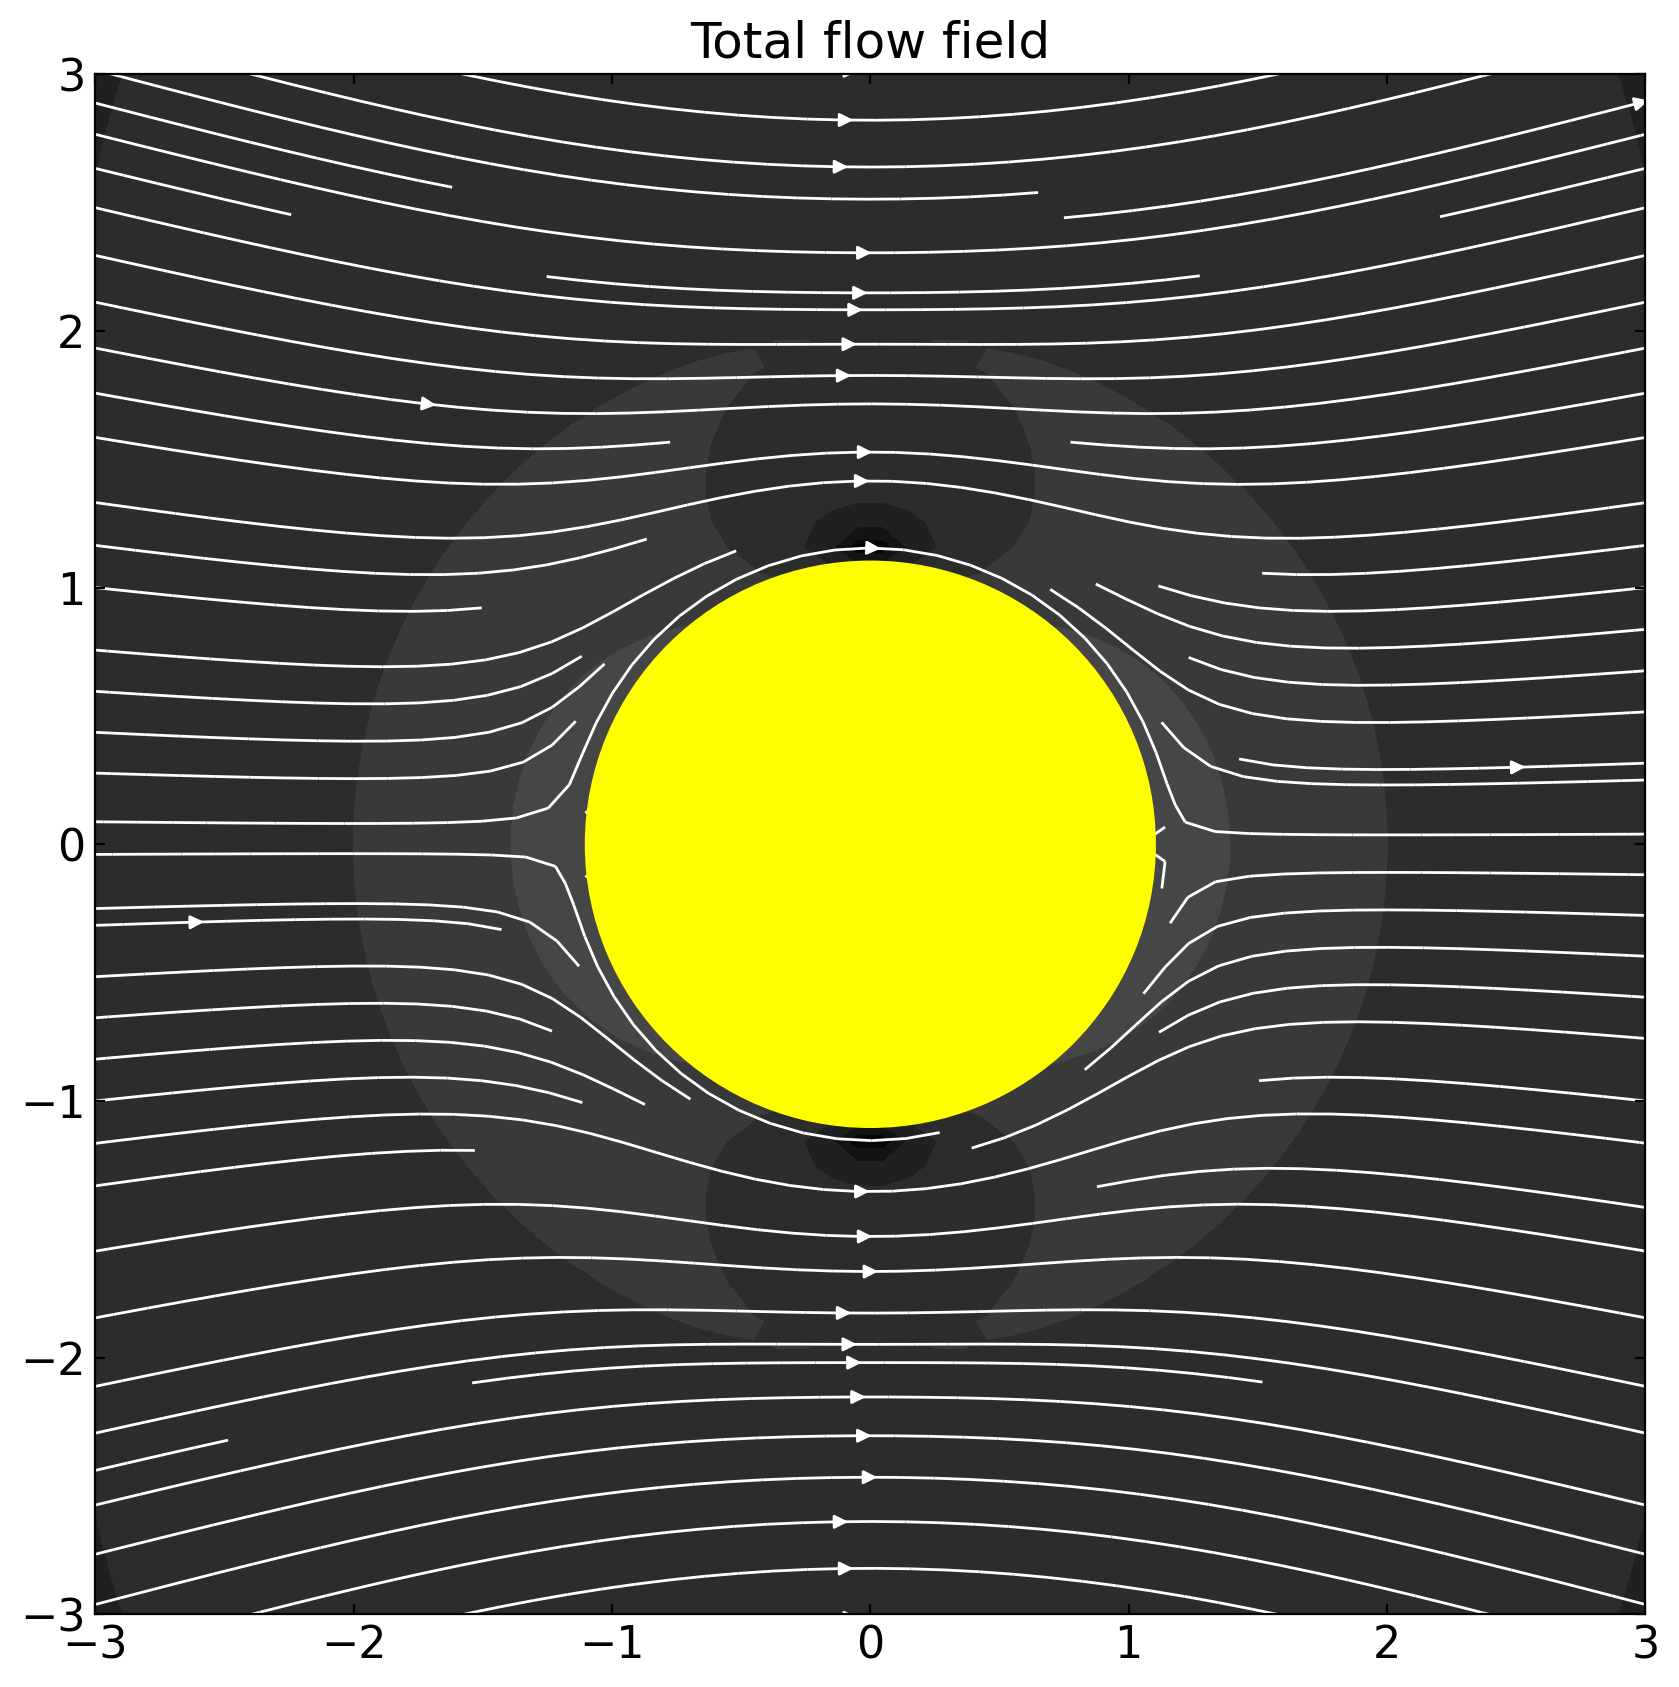

In [46]:
X,Y=np.meshgrid(x,y)
mask=np.sqrt(X**2+Y**2)<=1.9

fig,ax=plt.subplots(1,1,figsize=(10,10))
mag=np.sqrt(uu**2+vv**2)
plt.contourf(X,Y,np.log(mag),levels=20,cmap='gray',zorder=-2)
plt.streamplot(X,Y,uu.transpose(),vv.transpose(),density=[5,5],linewidth=1,color="w", maxlength=100,zorder=-1)
circle1 = plt.Circle((0, 0), 1.1*a/2, lw=1, color='yellow')
ax.add_artist(circle1)
plt.title('Total flow field')
plt.xlim(-3,3)
plt.ylim(-3,3)

plt.show()